In [2]:
# INITIAL SETUP
import os
import sys

if os.path.basename(os.getcwd()) == "testing":
    os.chdir(os.path.dirname(os.getcwd()))
    sys.path.append(os.getcwd())

import numpy as np
import torch
from lossless.component.coolchic import CoolChicEncoder
from lossless.configs.config import args, str_args
from lossless.training.loss import loss_function
from lossless.training.manager import ImageEncoderManager
from lossless.util.command_line_args_loading import load_args
from lossless.util.image_loading import load_image_as_tensor
from lossless.util.logger import TrainingLogger
from lossless.util.parsecli import get_coolchic_param_from_args

torch.autograd.set_detect_anomaly(True)
torch.set_float32_matmul_precision("high")
torch.use_deterministic_algorithms(True)

# ==========================================================================================
# LOAD COMMAND LINE ARGS AND IMAGE
# ==========================================================================================
command_line_args = load_args(
    notebook_overrides={
        "image_index": 8,
        "encoder_gain": 64,
        "color_space": "YCoCg",
        "use_image_arm": True,
    }
)
im_path = args["input"][command_line_args.image_index]
im_tensor, colorspace_bitdepths = load_image_as_tensor(
    im_path, device="cpu", color_space=command_line_args.color_space
)
# ==========================================================================================
# LOAD PRESETS, COOLCHIC PARAMETERS
# ==========================================================================================
image_encoder_manager = ImageEncoderManager(
    preset_name=args["preset"], colorspace_bitdepths=colorspace_bitdepths
)

encoder_param = get_coolchic_param_from_args(
    args,
    "lossless",
    image_size=(im_tensor.shape[2], im_tensor.shape[3]),
    use_image_arm=command_line_args.use_image_arm,
    encoder_gain=command_line_args.encoder_gain,
)
coolchic = CoolChicEncoder(param=encoder_param)
coolchic.load_state_dict(
    torch.load(
        "../logs_cluster/logs/07_01_2026_YCoCg_arm_smol_no_color_regression_gain_test_multiarm_Kodak/trained_models/2026_01_07__22_17_02__trained_coolchic_kodak_kodim09_img_rate_3.0264382362365723.pth"
    )
)

coolchic.eval()
coolchic.to_device("cpu")
with torch.no_grad():
    raw_synth_out, decoder_side_latent = coolchic.get_latents_raw_synth_out(AC_MAX_VAL=31)
    print("raw_synth_out:", raw_synth_out.shape)
    print("flat_decoder_side_latent:", len(decoder_side_latent))

Converting image to YCoCg color space
raw_synth_out: torch.Size([1, 6, 768, 512])
flat_decoder_side_latent: 7


In [3]:
from lossless.nnquant.quantizemodel import quantize_model

coolchic = quantize_model(
    coolchic,
    im_tensor,
    image_encoder_manager,
    None,
)

Best loss for module arm: Loss: 2.7754247188568115, Rate NN: 0.0023964776191860437, Rate Latent: 0.1461026817560196, Rate Img: 2.626925468444824
Best loss for module image_arm: Loss: 2.807023763656616, Rate NN: 0.03399573266506195, Rate Latent: 0.1461026817560196, Rate Img: 2.626925468444824
Best loss for module synthesis: Loss: 2.8120644092559814, Rate NN: 0.03903622180223465, Rate Latent: 0.1461026817560196, Rate Img: 2.626925468444824
Best loss for module upsampling: Loss: 2.8125009536743164, Rate NN: 0.0394727922976017, Rate Latent: 0.1461026817560196, Rate Img: 2.626925468444824

Time quantize_model(): 168.3 seconds



In [5]:
with torch.no_grad():
    # Forward pass with no quantization noise
    predicted_prior = coolchic.forward(
        image=im_tensor,
        quantizer_noise_type="none",
        quantizer_type="hardround",
        AC_MAX_VAL=32,
        flag_additional_outputs=False,
    )
    predicted_priors_rates = loss_function(
        predicted_prior,
        im_tensor,
        rate_mlp_bpd=0.0,
        colorspace_bitdepths=colorspace_bitdepths,
    )
    print(predicted_priors_rates)

Loss: 2.899044990539551, Rate NN: 0.0, Rate Latent: 0.14649131894111633, Rate Img: 2.752553701400757


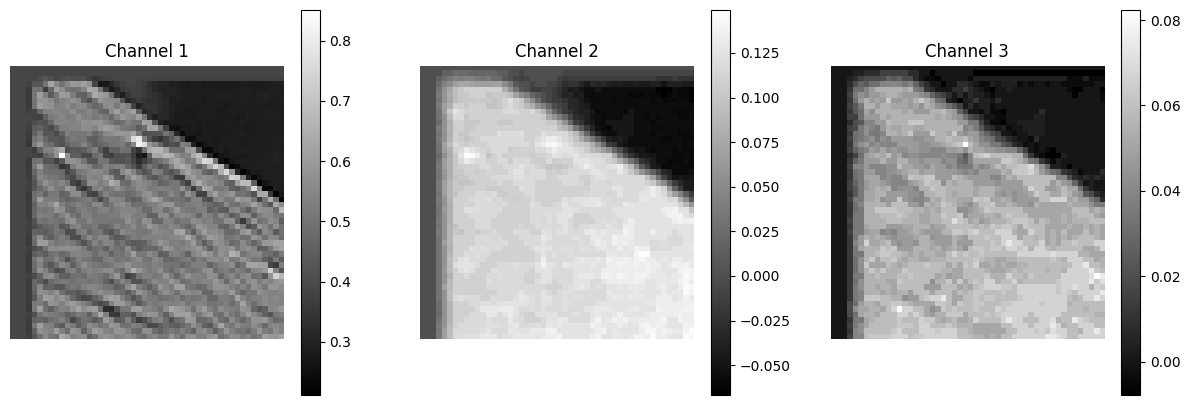

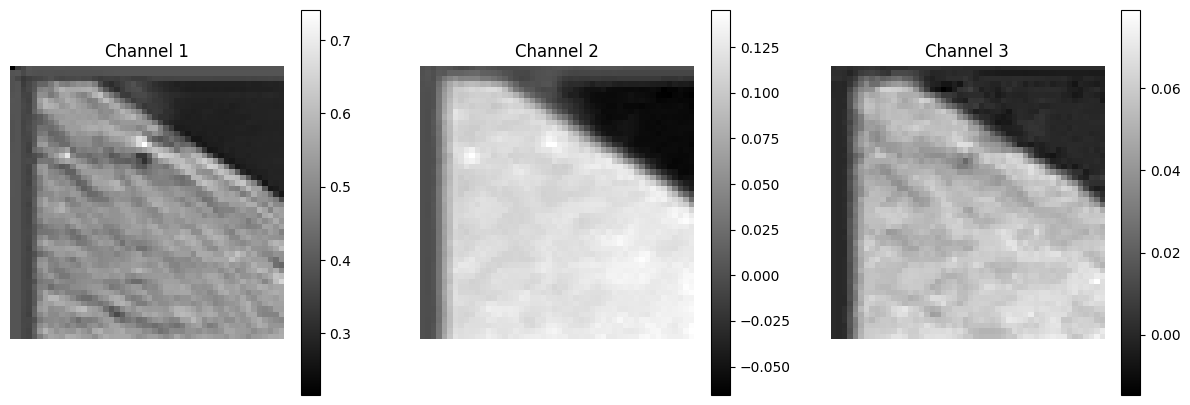

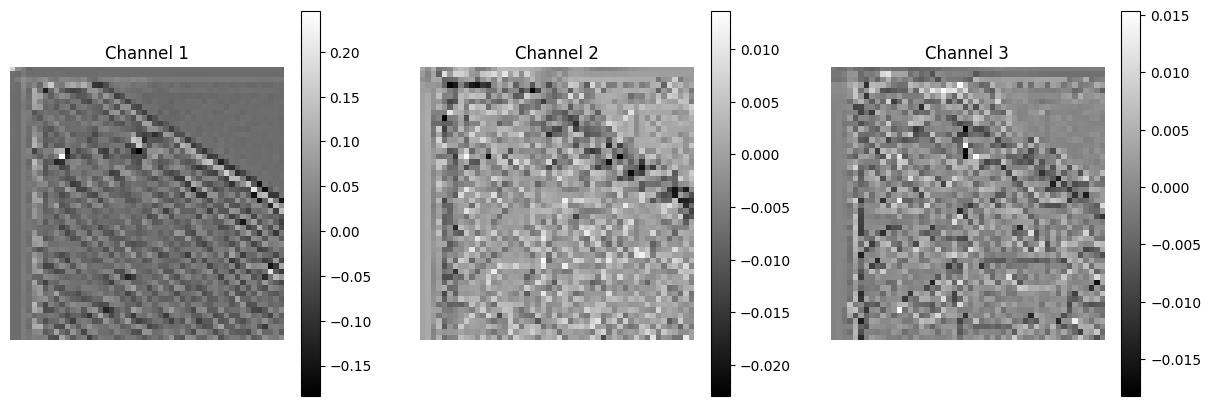

In [24]:
# CROP IMAGE AND PLOT CHANNELS
import matplotlib.pyplot as plt

def plot_image_by_channels(image_tensor: torch.Tensor):
    image_np = image_tensor[0].permute(1, 2, 0).cpu().numpy()
    num_channels = image_np.shape[2]
    fig, axes = plt.subplots(1, num_channels, figsize=(5 * num_channels, 5))
    for i in range(num_channels):
        ax = axes[i]  # type: ignore
        im = ax.imshow(image_np[:, :, i], cmap="gray")
        ax.set_title(f"Channel {i+1}")
        ax.axis("off")
        fig.colorbar(im, ax=ax)
    plt.show()

tmp_off, tmp_size = 0, 50
offset_x, offset_y, width, height = tmp_off, tmp_off, tmp_size, tmp_size
reduced_raw_synth_out = torch.clone(raw_synth_out[:, :, offset_y:offset_y+height, offset_x:offset_x+width].to("cpu"))
reduced_im_tensor = torch.clone(im_tensor[:, :, offset_y:offset_y+height, offset_x:offset_x+width].to("cpu"))
reduced_mu = predicted_prior["mu"][:, :, offset_y:offset_y+height, offset_x:offset_x+width].to("cpu")
reduced_scale = predicted_prior["scale"][:, :, offset_y:offset_y+height, offset_x:offset_x+width].to("cpu")


# plot_image_by_channels(reduced_raw_synth_out)
plot_image_by_channels(reduced_im_tensor)
plot_image_by_channels(reduced_mu)
plot_image_by_channels(reduced_im_tensor - reduced_mu)

In [6]:
# import constriction
# import lossless.util.color_transform as color_transform
# import torch
# from lossless.io.distributions import calculate_probability_distribution
# from lossless.io.encoding_interfaces.base_interface import EncodeDecodeInterface
# from lossless.io.types import POSSIBLE_ENCODING_DISTRIBUTIONS
# import struct

# testing_stop = 10


# def encode_quick_check(
#     im_tensor: torch.Tensor,
#     mu: torch.Tensor,
#     scale: torch.Tensor,
#     color_bitdepths: color_transform.ColorBitdepths,
#     distribution: POSSIBLE_ENCODING_DISTRIBUTIONS = "logistic",
#     output_path="./test-workdir/encoder_size_test/coolchic_encoded_image_quick_check.binary",
# ):
#     enc = constriction.stream.stack.AnsCoder()  # type: ignore
#     bits_theoretical = 0
#     im_tensor_flat = im_tensor.permute(0, 2, 3, 1).reshape(-1)
#     mu_flat = mu.permute(0, 2, 3, 1).reshape(-1)
#     scale_flat = scale.permute(0, 2, 3, 1).reshape(-1)

#     with torch.no_grad():
#         symbols_to_encode = []
#         prob_distributions = []
#         raw_values_of_symbols_to_encode = []
#         channel_indices = []
#         for idx in range(im_tensor_flat.shape[0]):
#             ch_ind = idx % im_tensor.shape[1]
#             mu_val = mu_flat[idx]
#             scale_val = scale_flat[idx]
#             mu_shifted_for_encoding = (
#                 mu_val
#                 - color_bitdepths.ranges_int[ch_ind][0] / color_bitdepths.scaling_factors[ch_ind]
#             )

#             channel_indices.append(ch_ind)
#             prob_distributions.append(
#                 calculate_probability_distribution(
#                     mu_shifted_for_encoding,
#                     scale_val,
#                     color_bitdepths=color_bitdepths,
#                     distribution=distribution,
#                     channel_idx=ch_ind,
#                 )
#             )
#             raw_values_of_symbols_to_encode.append(int(im_tensor_flat[idx].item() * 255))
#             symbols_to_encode.append(
#                 raw_values_of_symbols_to_encode[-1] - color_bitdepths.ranges_int[ch_ind][0]
#             )
#             bits_theoretical += -torch.log2(prob_distributions[-1][symbols_to_encode[-1]]).item()

#         for symbol_index, symbol_to_encode, prob_distribution in zip(
#             list(range(len(symbols_to_encode))),
#             reversed(symbols_to_encode),
#             reversed(prob_distributions),
#         ):
#             model = constriction.stream.model.Categorical(  # type: ignore
#                 prob_distribution.detach().cpu().numpy(), perfect=False
#             )
#             try:
#                 enc.encode_reverse(symbol_to_encode, model)
#             except Exception as e:
#                 print(f"probability: {prob_distribution}")
#                 print(f"Error encoding symbol {symbol_to_encode} at index {symbol_index}")
#                 raise e

#     bitstream = enc.get_compressed()
#     bitstream.tofile(output_path)

#     print(f"Theoretical bits per sub pixel: {bits_theoretical/len(symbols_to_encode)}")

#     return bitstream, raw_values_of_symbols_to_encode, prob_distributions, channel_indices


# def encode_with_predictor(
#     enc_dec_interface: EncodeDecodeInterface,
#     logger: TrainingLogger | None,
#     distribution: POSSIBLE_ENCODING_DISTRIBUTIONS = "logistic",
#     output_path: str | None = "./test-workdir/encoder_size_test/coolchic_encoded_image.binary",
#     bpd_normlization_constant: float = 1.0,
# ):
#     enc_dec_interface.reset_iterators()

#     enc = constriction.stream.stack.AnsCoder()  # type: ignore
#     bits_theoretical = 0

#     with torch.no_grad():
#         symbols_to_encode = []
#         prob_distributions = []
#         raw_values_of_symbols_to_encode = []
#         channel_indices = []
#         while True:
#             try:
#                 features = enc_dec_interface.get_next_predictor_features()
#                 mu, scale = enc_dec_interface.get_pdf_parameters(features)

#                 ch_ind = enc_dec_interface.get_channel_idx()
#                 channel_indices.append(ch_ind)
#                 prob_distributions.append(
#                     calculate_probability_distribution(
#                         mu
#                         - enc_dec_interface.ct_range.ranges_int[ch_ind][0]
#                         / enc_dec_interface.ct_range.scaling_factors[ch_ind],
#                         scale,
#                         color_bitdepths=enc_dec_interface.ct_range,
#                         distribution=distribution,
#                         channel_idx=ch_ind,
#                     )
#                 )
#                 raw_values_of_symbols_to_encode.append(
#                     (
#                         enc_dec_interface.get_current_element()
#                         * enc_dec_interface.ct_range.scaling_factors[ch_ind]
#                     )
#                     .int()
#                     .item()
#                 )
#                 symbols_to_encode.append(
#                     raw_values_of_symbols_to_encode[-1]
#                     - enc_dec_interface.ct_range.ranges_int[ch_ind][0]
#                 )
#                 bits_theoretical += -torch.log2(
#                     prob_distributions[-1][symbols_to_encode[-1]]
#                 ).item()
#                 enc_dec_interface.advance_iterators()
#             except StopIteration:
#                 break

#         for symbol_index, symbol_to_encode, prob_distribution in zip(
#             list(range(len(symbols_to_encode))),
#             reversed(symbols_to_encode),
#             reversed(prob_distributions),
#         ):
#             model = constriction.stream.model.Categorical(  # type: ignore
#                 prob_distribution.detach().cpu().numpy(), perfect=False
#             )
#             try:
#                 enc.encode_reverse(symbol_to_encode, model)
#             except Exception as e:
#                 exception_string = (
#                     f"probability: {prob_distribution}\n"
#                     + f"Error encoding symbol {symbol_to_encode} at index {symbol_index}"
#                 )
#                 if logger is not None:
#                     logger.log_result(exception_string)
#                 else:
#                     print(exception_string)
#                 raise e

#     bitstream = enc.get_compressed()
#     if output_path is not None:
#         bitstream.tofile(output_path)
#         with open(output_path, "rb") as f:
#             original_data = f.read()
#         with open(output_path, "wb") as f:
#             f.write(enc_dec_interface.get_packing_parameters())
#             f.write(original_data)

#     theoretical_bpd_string = f"Theoretical bits per sub pixel: {bits_theoretical/len(symbols_to_encode)*bpd_normlization_constant}"
#     if logger is not None:
#         logger.log_result(theoretical_bpd_string)
#     else:
#         print(theoretical_bpd_string)
#     return bitstream, raw_values_of_symbols_to_encode, prob_distributions, channel_indices


# def decode_quick_check(
#     prob_distributions: list[torch.Tensor],
#     channel_indices: list[int],
#     bitstream,
#     bitstream_path: str | None = "./test-workdir/encoder_size_test/coolchic_encoded_image.binary",
#     ct: color_transform.ColorBitdepths = color_transform.YCoCgBitdepths(),
#     offset: int = 4,
# ):
#     if bitstream_path is not None:
#         with open(bitstream_path, "rb") as f:
#             header = f.read(offset)  # 3 integers * 4 bytes each
#             num_symbols = struct.unpack("i" * (offset // 4), header)
#         bitstream = np.fromfile(bitstream_path, dtype=np.uint32, offset=offset)

#     dec = constriction.stream.stack.AnsCoder(bitstream)  # type: ignore

#     decoded_symbols = []
#     with torch.no_grad():
#         for i, prob_distribution in enumerate(prob_distributions):
#             prob_array = prob_distribution.detach().cpu().flatten().numpy()
#             model = constriction.stream.model.Categorical(prob_array, perfect=False)  # type: ignore
#             decoded_char = (
#                 torch.tensor(dec.decode(model, 1)[0]) + ct.ranges_int[channel_indices[i]][0]
#             )
#             decoded_symbols.append(decoded_char.item())
#     return decoded_symbols


# def decode_with_predictor(
#     enc_dec_interface: EncodeDecodeInterface,
#     bitstream,
#     bitstream_path: str | None = "./test-workdir/encoder_size_test/coolchic_encoded_image.binary",
#     distribution: POSSIBLE_ENCODING_DISTRIBUTIONS = "logistic",
# ):
#     enc_dec_interface.reset_iterators()
#     if bitstream_path is not None:
#         with open(bitstream_path, "rb") as f:
#             offset = enc_dec_interface.set_packing_parameters(f)
#         bitstream = np.fromfile(bitstream_path, dtype=np.uint32, offset=offset)
#     dec = constriction.stream.stack.AnsCoder(bitstream)  # type: ignore

#     with torch.no_grad():
#         symbols_decoded = []
#         prob_distributions = []
#         while True:
#             try:
#                 features = enc_dec_interface.get_next_predictor_features()
#                 mu, scale = enc_dec_interface.get_pdf_parameters(features)
#                 ch_ind = enc_dec_interface.get_channel_idx()
#                 prob_distributions.append(
#                     calculate_probability_distribution(
#                         mu
#                         - enc_dec_interface.ct_range.ranges_int[ch_ind][0]
#                         / enc_dec_interface.ct_range.scaling_factors[ch_ind],
#                         scale,
#                         color_bitdepths=enc_dec_interface.ct_range,
#                         distribution=distribution,
#                         channel_idx=ch_ind,
#                     )
#                 )
#                 model = constriction.stream.model.Categorical(  # type: ignore
#                     prob_distributions[-1].detach().cpu().numpy(), perfect=False
#                 )
#                 symbols_decoded.append(
#                     (
#                         torch.tensor(dec.decode(model, 1)[0])
#                         + enc_dec_interface.ct_range.ranges_int[ch_ind][0]
#                     ).item()
#                 )
#                 enc_dec_interface.set_decoded_element(
#                     symbols_decoded[-1] / enc_dec_interface.ct_range.scaling_factors[ch_ind]
#                 )
#                 enc_dec_interface.advance_iterators()
#             except StopIteration:
#                 break
#     return symbols_decoded, prob_distributions

In [7]:
# from _io import BufferedReader
# from lossless.io.encoding_interfaces.base_interface import EncodeDecodeInterface
# from lossless.util.color_transform import ColorBitdepths


# class LatentEncodeDecodeInterface(EncodeDecodeInterface):
#     def __init__(self, data: list[torch.Tensor], model: CoolChicEncoder, ct_range:ColorBitdepths) -> None:
#         # latents are a list of tensors of shape [1, C, H, W]
#         super().__init__(data, model, ct_range)
#         self.current_latent_idx = 0
#         self.current_spatial_pos = [0, 0, 0, 0]
#         self.header_size = 4

#     def reset_iterators(self) -> None:
#         self.current_latent_idx = 0
#         self.current_spatial_pos = [0, 0, 0, 0]

#     def _iterator_to_flat_index(self) -> int:
#         latent_shape = self.data[self.current_latent_idx].shape
#         flat_index = 0
#         nested_multiplier = 1
#         for index in range(len(self.current_spatial_pos) - 1, -1, -1):
#             flat_index += self.current_spatial_pos[index] * nested_multiplier
#             nested_multiplier *= latent_shape[index]
#         return flat_index

#     def _flat_index_to_iterator(self, flat_index: int) -> list[int]:
#         latent_shape = self.data[self.current_latent_idx].shape
#         res = [0, 0, 0, 0]
#         for dim in range(len(self.current_spatial_pos) - 1, -1, -1):
#             res[dim] = flat_index % latent_shape[dim]
#             flat_index = flat_index // latent_shape[dim]
#         return res

#     def advance_iterators(self, testing_stop: int = -1) -> None:
#         if self.current_latent_idx >= len(self.data):
#             raise StopIteration("All latents have been processed.")
#         flat_index = self._iterator_to_flat_index()
#         flat_index += 1
#         if testing_stop > 0 and flat_index > testing_stop:
#             raise StopIteration("Partial stop for testing.")

#         if flat_index >= self.data[self.current_latent_idx].numel():
#             # move to next latent
#             self.current_latent_idx += 1
#             if self.current_latent_idx >= len(self.data):
#                 raise StopIteration("All latents have been processed.")
#             self.current_spatial_pos = [0, 0, 0, 0]
#             return
#         # compute new spatial pos from flat index
#         self.current_spatial_pos = self._flat_index_to_iterator(flat_index)

#     def get_next_predictor_features(self) -> torch.Tensor:
#         b, c, h, w = self.current_spatial_pos
#         latent = self.data[self.current_latent_idx][b, c, :, :]
#         context = self.model.arm.get_neighbor_context(latent, h=h, w=w)
#         return context

#     def get_pdf_parameters(self, features: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
#         # I assume that the features have shape [1, context_size]
#         # print("Getting PDF parameters for latent index", self.current_latent_idx, "at position", self.current_spatial_pos)
#         # print("Features:", features.dtype, features.shape, features)
#         # raise StopExecution()
#         mu, scale, log_scale = self.model.arm(features)
#         return mu[0], scale[0]

#     def get_current_element(self):
#         b, c, h, w = self.current_spatial_pos
#         return self.data[self.current_latent_idx][b, c, h, w]

#     def set_decoded_element(self, element) -> None:
#         b, c, h, w = self.current_spatial_pos
#         self.data[self.current_latent_idx][b, c, h, w] = element

#     def get_packing_parameters(self) -> bytes:
#         # this could
#         total_elems = sum([latent.numel() for latent in self.data])
#         return struct.pack("i", total_elems)

#     def set_packing_parameters(self, bitstream: BufferedReader) -> int:
#         header = bitstream.read(self.header_size)
#         (total_elems,) = struct.unpack("i", header)
#         # FIXME: currently we ignore the packing parameters for latents
#         # as we assume fixed size latents known from the model
#         return self.header_size

#     def get_channel_idx(self) -> int:
#         return self.current_spatial_pos[1]


In [6]:
import copy
from lossless.util.color_transform import LatentBitdepths
from lossless.io.encoding_interfaces.image_encoding_interface import ImageEncodeDecodeInterface
from lossless.io.encoding_interfaces.latent_encoding_interface import LatentEncodeDecodeInterface
from lossless.io.decode_with_predictor import decode_with_predictor
from lossless.io.encode_with_predictor import encode_with_predictor

testing_stop = -1
reduced_decoder_side_latent = copy.deepcopy(decoder_side_latent)

reduced_im_tensor = torch.clone(im_tensor)
reduced_raw_synth_out = torch.clone(raw_synth_out)
encode_decode_interface = ImageEncodeDecodeInterface(
    data=(torch.clone(reduced_im_tensor), torch.clone(reduced_raw_synth_out)), model=coolchic, ct_range=colorspace_bitdepths
)
# encode_decode_interface = LatentEncodeDecodeInterface(
#     data=reduced_decoder_side_latent, model=coolchic, ct_range=LatentBitdepths()
# )
bitstream, symbols_to_encode, prob_distributions_enc, channel_indices = encode_with_predictor(
    enc_dec_interface=encode_decode_interface,
    distribution="logistic",
    output_path=None,
    logger=None,
)
# symbols_enc_tensor = torch.tensor(symbols_to_encode)

# symbols_decoded, prob_distributions_dec = decode_with_predictor(
#     enc_dec_interface=encode_decode_interface,
#     distribution="logistic",
#     bitstream=bitstream,
#     bitstream_path=None,
# )
# symbols_dec_tensor = torch.tensor(symbols_decoded)
# assert torch.equal(
#     symbols_enc_tensor, symbols_dec_tensor
# ), "Decoded symbols do not match encoded symbols!"
print(bitstream.nbytes * 8 / im_tensor.numel())

Theoretical bits per sub pixel: 2.7728039516720173
2.7728678385416665


In [15]:
total_latent_size = sum([latent.numel() for latent in decoder_side_latent])
print(total_latent_size / im_tensor.numel())

0.4444173177083333


In [12]:
bitstream.nbytes * 8 / im_tensor.numel()

3.0145128038194446

In [13]:
3.0145128038194446 + 0.3629286024305556

3.37744140625